In [1]:
import pandas as pd
import torch
from einops import rearrange
from util import Keypoint, draw_bodypose
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [2]:
df = pd.read_csv('data/poses.csv')
df['class'].value_counts()

class
stand    744
walk     722
wave     692
squat    668
Name: count, dtype: int64

In [3]:
df = pd.read_csv('data/poses.csv')
df = df[~(df['class'].isin(['squat', 'wave']))]
df = df.drop('class', axis=1)
df = df[~(df == 0).any(axis=1)]
poses = torch.tensor(df.values, dtype=torch.float32)
poses_rear = rearrange(poses, 'n (ps p) -> n ps p', p=2)

In [4]:
poses_rear.shape

torch.Size([800, 18, 2])

In [5]:
def translate_to_keyppoints(pose):
    return [Keypoint(x, y, True) if 0.0 < x < 1.0 and 0.0 < y < 1.0 else None for x, y in pose]

In [6]:
def create_image_grid_with_borders(images, rows, cols, border=1, border_color='white'):
    if not images:
        raise ValueError("No images to compose.")

    # Assuming all images are the same size
    w, h = images[0].size

    # Size of the grid, accounting for borders
    grid_width = cols * w + (cols - 1) * border
    grid_height = rows * h + (rows - 1) * border

    # Create a new image with a white background
    grid_img = Image.new('RGB', (grid_width, grid_height), color='white')
    draw = ImageDraw.Draw(grid_img)

    for i, img in enumerate(images):
        # Calculate grid position
        grid_x = (i % cols) * (w + border)
        grid_y = (i // cols) * (h + border)

        # Paste the image into position
        grid_img.paste(img, (grid_x, grid_y))

        # Draw vertical borders
        if (i % cols) != (cols - 1):  # Avoid drawing on the last column
            draw.line([(grid_x + w, grid_y), (grid_x + w, grid_y + h)], fill=border_color, width=border)

        # Draw horizontal borders
        if (i // cols) != (rows - 1):  # Avoid drawing on the last row
            draw.line([(grid_x, grid_y + h), (grid_x + w, grid_y + h)], fill=border_color, width=border)

    return grid_img

In [7]:
def transform_poses(poses, scale_y, move_x, move_y, ratio):
    default_ratio = 1.6
    new_col = torch.full((poses.shape[0], poses.shape[1], 1), ratio, dtype=torch.float32)
    poses = poses.clone()
    mean_x = poses[:, :, 0].mean(axis=1).unsqueeze(1)
    mean_y = poses[:, :, 1].mean(axis=1).unsqueeze(1)
    poses[:, :, 0] -= mean_x
    poses[:, :, 1] -= mean_y
    poses[:, :, 0] *= scale_y * ratio * default_ratio
    poses[:, :, 1] *= scale_y
    poses[:, :, 0] += mean_x + move_x
    poses[:, :, 1] += mean_y + move_y
    return torch.cat((poses, new_col), axis=2)

In [8]:
sizes = [(1344, 768), (1024, 1024), (768, 1344)]
# random.seed(1232)
idx = 2
w, h = sizes[idx]
transforms = [
    (1.5, .0, .2, *sizes[0]),
    (2.5, .0, .3, *sizes[0]),
    (2.5, .0, .5, *sizes[0]),
    (3.5, .0, .2, *sizes[0]),
    (1.5, -.3, .2, *sizes[0]),
    (2.5, -.3, .3, *sizes[0]),
    (2.5, -.3, .5, *sizes[0]),
    (3.5, -.3, .2, *sizes[0]),
    (1.5, .3, .2, *sizes[0]),
    (2.5, .3, .3, *sizes[0]),
    (2.5, .3, .5, *sizes[0]),
    (3.5, .3, .2, *sizes[0]),
    (1.5, .0, .2, *sizes[1]),
    (2.5, .0, .3, *sizes[1]),
    (2.5, .0, .5, *sizes[1]),
    (3.5, .0, .2, *sizes[1]),
    (3.5, .0, .5, *sizes[1]),
    (1.5, -.3, .2, *sizes[1]),
    (1.5, -.3, -.2, *sizes[1]),
    (2.5, -.3, .3, *sizes[1]),
    (2.5, -.3, .5, *sizes[1]),
    (3.5, -.3, .2, *sizes[1]),
    (1.5, .3, .2, *sizes[1]),
    (2.5, .3, .3, *sizes[1]),
    (2.5, .3, .4, *sizes[1]),
    (3.5, .3, 0.1, *sizes[1]),
    (1.5, .0, .2, *sizes[2]),
    (1.1, .0, -.2, *sizes[2]),
    (2.5, .0, .3, *sizes[2]),
    (2.5, .0, .0, *sizes[2]),
    (2.5, .0, .5, *sizes[2]),
    (3.5, .0, .2, *sizes[2]),
    (3.5, .0, .5, *sizes[2]),
    (1.5, -.3, .2, *sizes[2]),
    (1.5, -.3, -.2, *sizes[2]),
    (2.5, -.3, .3, *sizes[2]),
    (2.5, -.3, .5, *sizes[2]),
    (3.5, -.3, .2, *sizes[2]),
    (1.5, .3, .2, *sizes[2]),
    (2.5, .3, .3, *sizes[2]),
    (2.5, .3, .4, *sizes[2]),
    (3.5, .3, 0.1, *sizes[2]),
]
lst = []
for tr in transforms:
    lst.append(transform_poses(poses_rear, tr[0], tr[1], tr[2], tr[4] / tr[3]))
poses_tmp = torch.cat(lst)

In [21]:
mask = (poses_tmp[..., 0] < 0) | (poses_tmp[..., 0] > 1) | (poses_tmp[..., 1] < 0) | (poses_tmp[..., 1] > 1)
sm = mask.sum(dim=1)
filtered_poses = poses_tmp[sm >= 8]
final_poses = rearrange(filtered_poses[:, :, :2], 'n ps p -> n (ps p)')
final_ratios = filtered_poses[:, 0, 2]
torch.save(final_poses, f'data/poses_keypoints.pt')
torch.save(final_ratios, f'data/poses_ratios.pt')

In [25]:
poses = rearrange(final_poses, 'n (ps p) -> n ps p', p=2)

In [27]:
mask = (poses[..., 0] < 0) | (poses[..., 0] > 1) | (poses[..., 1] < 0) | (poses[..., 1] > 1)
poses[mask] = -1

In [32]:
torch.save(rearrange(poses, 'n ps p -> n (ps p)'), f'data/poses_with_missing.pt')

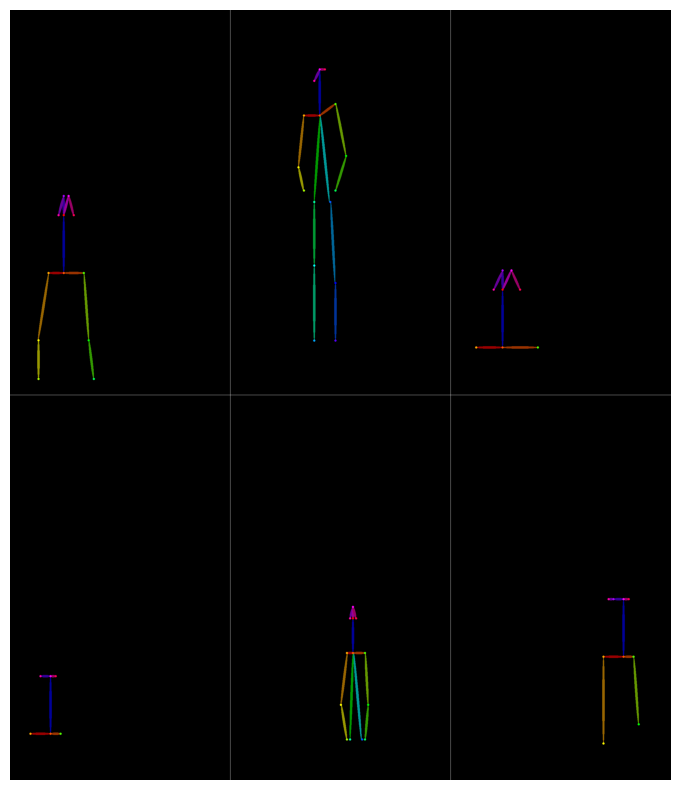

In [208]:
images = [Image.fromarray(draw_bodypose(np.zeros((h, w, 3), dtype=np.uint8), translate_to_keyppoints(poses_tmp[i].numpy()))) 
          for i in random.sample(range(0, poses_tmp.shape[0] + 1), 6)]
rows = 2
cols = 3
grid_img = create_image_grid_with_borders(images, rows, cols)
fig = plt.figure(figsize=(14, 10))
plt.imshow(grid_img)
plt.axis('off')
plt.show();